## Test fonction run exp

### 1. Imports

In [1]:
import torch
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt
import pprint
from time import time
import scipy.stats as stats 
pp = pprint.PrettyPrinter(indent=4,depth=6,width=80,compact=True)

In [2]:
import stat_reliability_measure.dev.torch_utils as t_u
import stat_reliability_measure.dev.torch_utils2 as t_u2
from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import ExpModelConfig
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_pyt2 as smc_pyt2

import stat_reliability_measure.dev.smc.smc_config as smc_config
import stat_reliability_measure.dev.smc.smc_config2 as smc_config2

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.imp_sampling.is_pyt as is_pyt
import stat_reliability_measure.dev.imp_sampling.is_config as is_config
import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 


### 2. Model & Data load

In [3]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epsilon_range=[0.08]
input_index=11
#good seed : torch_seed = 111,np_seed = 0 

/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded:  imagenet [random_seed = 0]
X.shape = torch.Size([15, 3, 224, 224]), y.shape = torch.Size([15])
Model accuracy: 0.75
Sample labels frequencies: 

("{'tench': 0.06666666666666667, 'goldfish': 0.06666666666666667, 'great white "
 "shark': 0.06666666666666667, 'tiger shark': 0.06666666666666667, 'hammerhead "
 "shark': 0.06666666666666667, 'electric ray': 0.06666666666666667, "
 "'stingray': 0.06666666666666667, 'cock': 0.06666666666666667, 'hen': "
 "0.06666666666666667, 'ostrich': 0.06666666666666667, 'brambling': "
 "0.06666666666666667, 'goldfinch': 0.06666666666666667, 'house finch': "
 "0.06666666666666667, 'junco': 0.06666666666666667, 'indigo bunting': "
 '0.06666666666666667}')
Plotting 15 ImageNet pictures


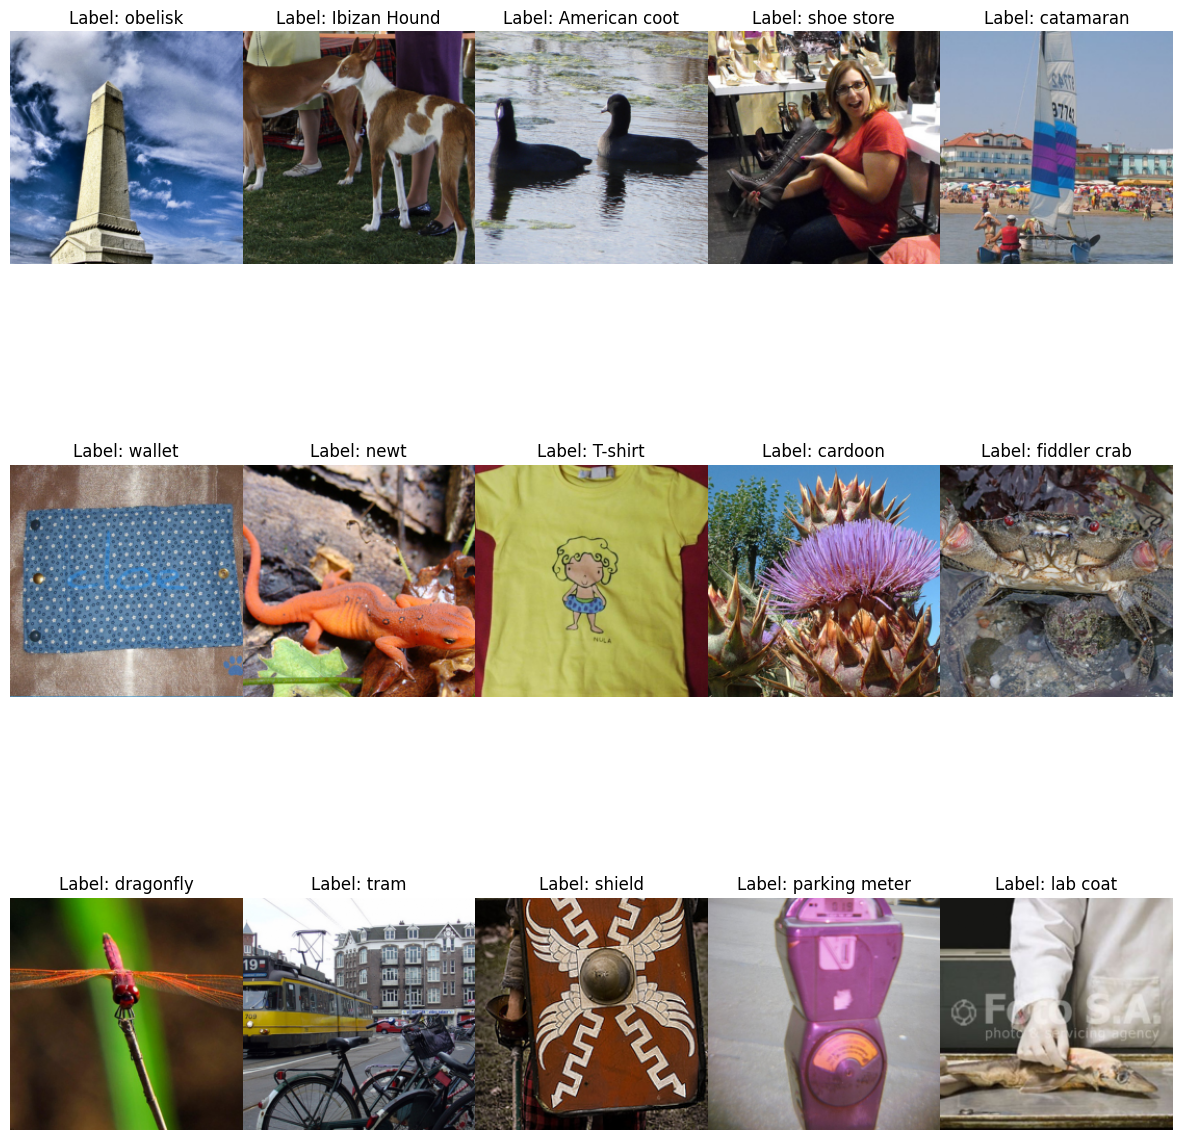

In [4]:
exp_config = config_.ExpModelConfig(dataset = 'imagenet', model_name = 'resnet18',data_dir = '../data/ImageNet', model_dir = '../models/ImageNet', device = device,
             torch_seed=42,np_seed=0,random_seed=0,shuffle=True, epsilon_range=epsilon_range,x_min=0.,x_max=1., input_index=input_index,real_uniform=False, 
             load_batch_size=20,
             noise_dist='uniform')
imagenet_simple_labels = t_u.get_imagenet_simple_labels()
exp_config.update()

print(f"Data loaded:  {exp_config.dataset} [random_seed = {exp_config.random_seed}]")
X_shape,y_shape = exp_config.X.shape,exp_config.y.shape

print(f"X.shape = {X_shape}, y.shape = {y_shape}")
y_numpy = exp_config.y.detach().cpu().numpy()
#print labels frequencies (real labels are given from imagenet_simple_labels)
labels, label_counts = np.unique(y_numpy,return_counts=True)
text_labels = [imagenet_simple_labels[i] for i in labels]
print(f"Model accuracy: {exp_config.sample_accuracy}")
print("Sample labels frequencies: \n" )
pp.pprint(f"{dict(zip(imagenet_simple_labels,label_counts/X_shape[0]))}")
x_0 = exp_config.X[input_index:input_index+1]
os.rmdir(exp_config.exp_log_path)
t_u.plot_imagenet_pictures(exp_config.X[:],exp_config.y[:],3,5)

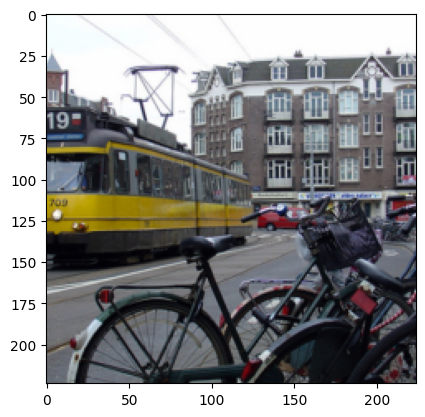

In [5]:
t_u.plot_tensor(exp_config.x_clean)

In [6]:
reload(is_pyt)

<module 'stat_reliability_measure.dev.imp_sampling.is_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/imp_sampling/is_pyt.py'>

In [7]:
N=128
k=18
X_normal = exp_config.gen(N)
dist_normal = torch.norm(X_normal,dim=-1)
G_X_normal = exp_config.G(X_normal)

percent_fail = (G_X_normal<=0).float().mean().item()
print(f"Percentage of failure in samples: {percent_fail}")
x_0 = exp_config.X[input_index:input_index+1]
index_topk = torch.topk(input=G_X_normal,k=k,largest=False, sorted=True).indices
print(f"h_score: {exp_config.h(X_normal)}")
print(f"h alt :{exp_config.h_alt(X_normal)}")
print(f"v_score: {exp_config.V(X_normal)}")
print(f"v score alt: {exp_config.V_alt(X_normal)}")

grad_v = exp_config.gradV(X_normal)[0][:2]

grad_v_alt = exp_config.gradV_alt(X_normal)[0][:2]

u = exp_config.normal_cdf_layer(X_normal.view(N,3,224,224))
del X_normal
logits_u = exp_config.model(u)
y_pred = torch.argmax( logits_u,-1)
delta_img = u-exp_config.x_clean
u_best = u[index_topk]
y_pred_best=y_pred[index_topk]
del u
#stats about delta_img
print(delta_img.min().item(),delta_img.max().item())
del delta_img
print(f" (gradv_autodiff-gradv_analytical)/gradv_autodiff:{((grad_v_alt-grad_v)/grad_v_alt).abs().max().item(),((grad_v_alt-grad_v)/grad_v_alt).abs().mean().item()}")
del grad_v,grad_v_alt


Percentage of failure in samples: 0.03125
h_score: tensor([ 0.0751, -0.4915, -0.5544, -0.6175, -0.9639, -1.1007, -0.7708, -0.7072,
        -0.8170, -0.5747, -0.2297, -1.0933, -1.1765, -0.2958, -0.1556, -0.7641,
        -0.6680, -0.6597, -1.0521, -1.3499, -0.7007, -0.7317, -1.1963, -0.2863,
        -0.9129, -1.1530, -0.4369, -0.8265, -0.8758, -0.7729, -0.8233, -0.2858,
        -1.0143, -1.2756, -1.0233, -0.8781, -1.5659, -0.5379, -0.8680, -0.6648,
        -0.4056, -0.8465, -0.6588, -0.7544, -0.4504, -0.5471, -0.7687, -0.7861,
        -0.5762, -0.8944, -0.3048, -0.8612, -1.0642,  0.0829, -0.0159, -0.6559,
        -0.5930, -1.4352, -0.5406, -0.9681,  0.2125, -0.9170, -0.4375, -0.6695,
        -0.9468, -1.5606, -0.9632, -0.2319, -0.7033, -1.0549, -0.4780, -0.8627,
        -1.4793, -0.9410, -0.2382, -1.1906, -1.0612, -0.8176, -0.0235, -1.6995,
        -0.6927, -0.8921, -0.8859, -0.8130, -0.7382, -0.7979, -0.8630, -0.8913,
        -0.7811, -0.4748, -0.1942, -0.3180, -0.2897, -0.7075, -0.5189

/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Distances between x_clean and x_attack: 

dist_linf_carlini: 0.009636729955673218
dist_linf_fmna: 0.0004279613494873047
dist_linf_mpp: 0.007827803492546082
Norms of the corresponding latent variables: 

norm_x_attack: 3.4730687141418457
norm_x_mpp: 1.9731465578079224
norm_x_LinfFMNA: 2.561414957046509
Norms of the corresponding latent variables: 

norm_x_attack: 3.4730687141418457
norm_x_mpp: 1.9731465578079224
norm_x_L2FMNA: 1.9440481662750244
Reconstruction distances: 

dist_Linf_reconstr: 0.0004279613494873047
dist_L2_reconstr : 0.16349563002586365
dist_L2 relative to dimension: 0.00042140288395874927
Time of the different attacks: 

time_carlini: 4.95482611656189
time_mpp: 0.13121390342712402
time_LinfFMNA: 0.778618335723877
time_L2FMNA: 0.7435741424560547


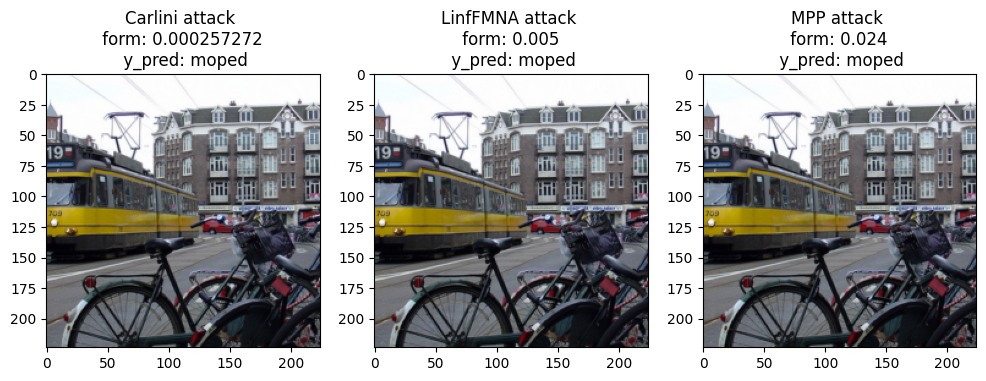

In [8]:
time_start = time()
x_attack= is_pyt.gaussian_space_attack(x_clean=exp_config.x_clean,y_clean=exp_config.y_clean,model=exp_config.model, normal_cdf_layer=exp_config.normal_cdf_layer,attack='Carlini',
                                       random_init=False).reshape((1,exp_config.d))
time_carlini = time()-time_start
dist_attack=torch.norm(x_attack).item()

form_attack=stats.norm.cdf(-dist_attack)
u_carlini=exp_config.normal_cdf_layer(x_attack)

y_pred_attack=torch.argmax(exp_config.model(u_carlini)).item()
y_carlini_text = t_u.imagenet_simple_labels[y_pred_attack]
dist_linf_carlini = (u_carlini-exp_config.x_clean).abs().max()
zero_latent=torch.zeros_like(x_attack).detach()
time_start = time()
x_mpp,nb_calls_mpp = is_pyt.mpp_search(grad_f= exp_config.gradG_alt, zero_latent=zero_latent, max_iter=20)
time_mpp = time()-time_start
form_mpp = stats.norm.cdf(-torch.norm(x_mpp).item())
u_mpp = exp_config.normal_cdf_layer(x_mpp)
y_mpp = torch.argmax(exp_config.model(u_mpp)).item()
y_mpp_text = t_u.imagenet_simple_labels[y_mpp]
dist_linf_mpp = (u_mpp-exp_config.x_clean).abs().max()
import foolbox as fb
fmodel=fb.models.PyTorchModel(model=exp_config.model, bounds = (0,1),)
linf_fmna = fb.attacks.LInfFMNAttack()
criterion = fb.criteria.Misclassification(exp_config.y_clean.unsqueeze(0))
time_start = time()
u_LinfFMNA = linf_fmna(model = fmodel, inputs=exp_config.x_clean.unsqueeze(0), criterion=criterion,epsilons=[0.15,])[0][0]
time_LinfFMNA = time()-time_start
dist_linf_fmna = (u_LinfFMNA-exp_config.x_clean).abs().max()
y_LinfFMNA = torch.argmax(exp_config.model(u_LinfFMNA)).item()
y_LinfFMNA_text = t_u.imagenet_simple_labels[y_LinfFMNA]
x_LinfFMNA=exp_config.normal_cdf_layer.inverse(u_LinfFMNA)
form_LinfFMNA = stats.norm.cdf(-torch.norm(x_LinfFMNA).item())
reconstr = exp_config.normal_cdf_layer(x_LinfFMNA)
dist_Linf_reconstr = (reconstr-exp_config.x_clean).abs().max()
dist_L2_reconstr = torch.norm(reconstr-exp_config.x_clean)


total_model=torch.nn.Sequential(exp_config.normal_cdf_layer,exp_config.model)
ftotal_model=fb.models.PyTorchModel(model=total_model, bounds = (-10,10),)
l2_fmna= fb.attacks.L2FMNAttack()
criterion = fb.criteria.Misclassification(exp_config.y_clean.unsqueeze(0))
x_0 = torch.zeros_like(exp_config.x_clean)
time_start = time()

x_L2FMNA = l2_fmna(model = ftotal_model, inputs=x_0.unsqueeze(0), criterion=criterion,epsilons=[10.])[0][0] 
time_L2FMNA = time()-time_start
#print the different attacks distances 
print(f"Distances between x_clean and x_attack: \n")
print(f"dist_linf_carlini: {dist_linf_carlini.item()}")
print(f"dist_linf_fmna: {dist_linf_fmna.item()}")
print(f"dist_linf_mpp: {dist_linf_mpp.item()}")

print(f"Norms of the corresponding latent variables: \n")
print(f"norm_x_attack: {torch.norm(x_attack).item()}")
print(f"norm_x_mpp: {torch.norm(x_mpp).item()}")
print(f"norm_x_LinfFMNA: {torch.norm(x_LinfFMNA).item()}")


print(f"Norms of the corresponding latent variables: \n")
print(f"norm_x_attack: {torch.norm(x_attack).item()}")
print(f"norm_x_mpp: {torch.norm(x_mpp).item()}")
print(f"norm_x_L2FMNA: {torch.norm(x_L2FMNA).item()}")

print(f"Reconstruction distances: \n")
print(f"dist_Linf_reconstr: {dist_Linf_reconstr.item()}")
print(f"dist_L2_reconstr : {dist_L2_reconstr.item()}")
print(f"dist_L2 relative to dimension: {dist_L2_reconstr.item()/np.sqrt(exp_config.d)}")


#print the time of the different attacks
print(f"Time of the different attacks: \n")
print(f"time_carlini: {time_carlini}")
print(f"time_mpp: {time_mpp}")
print(f"time_LinfFMNA: {time_LinfFMNA}")
print(f"time_L2FMNA: {time_L2FMNA}")

#plot the different attacks
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(u_carlini[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"Carlini attack \n form: {form_attack:.9f} \n y_pred: {y_carlini_text}")
plt.subplot(1,3,2)
plt.imshow(u_LinfFMNA[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"LinfFMNA attack \n form: {form_LinfFMNA:.3f} \n y_pred: {y_LinfFMNA_text}")
plt.subplot(1,3,3)
plt.imshow(u_mpp[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"MPP attack \n form: {form_mpp:.3f} \n y_pred: {y_mpp_text}")
plt.show()


Plotting 15 ImageNet pictures


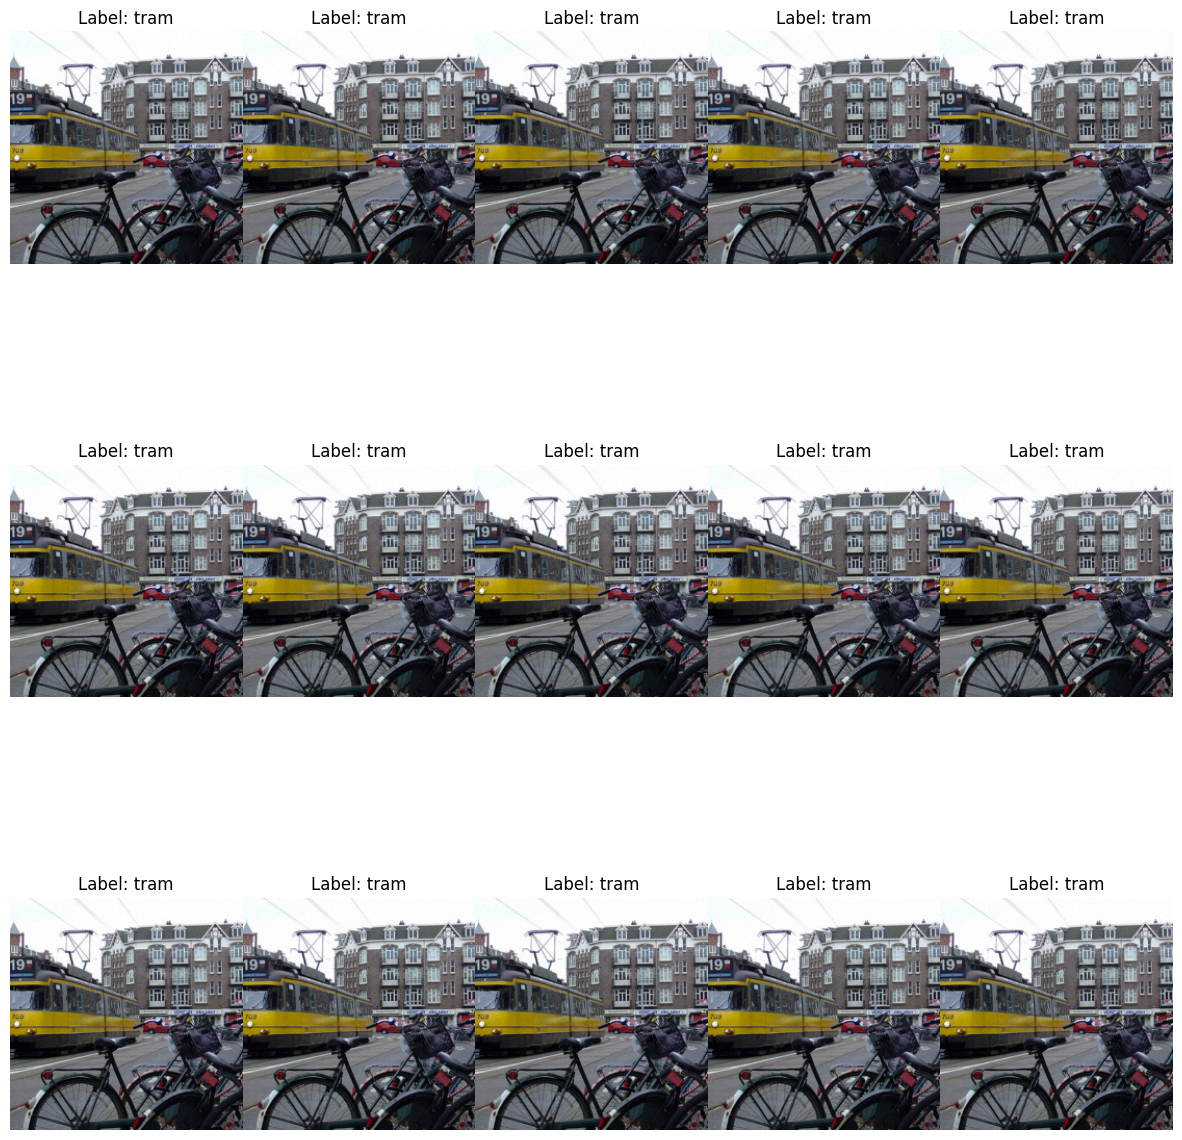

In [31]:
t_u.plot_imagenet_pictures(u_best[:],y_pred_best[:],3,5)

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [10]:

dataset='imagnet'
n_rep = 100 
method_ref='mala2'
method_ref_name='MALA_SMC'
N_ref = 128 
T_ref = 2
ess_ref = 0.5
alpha_ref = 0.25
n_rep_ref = 1
X = exp_config.X
y = exp_config.y
model = exp_config.model
input_index = exp_config.input_index


In [38]:
exp_config.X.requires_grad = True

In [39]:
x_0 = exp_config.X[0]

In [42]:
del exp_config
torch.cuda.empty_cache()

with parameters in {'N_range': [128], 'T_range': [2], 'ess_alpha_range': [0.5], 'alpha_range': [0.25], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: model, img_idx:0,eps:0.12, N: 128: T: 2: ess_alpha: 0.5: alpha: 0.25: L: 1


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


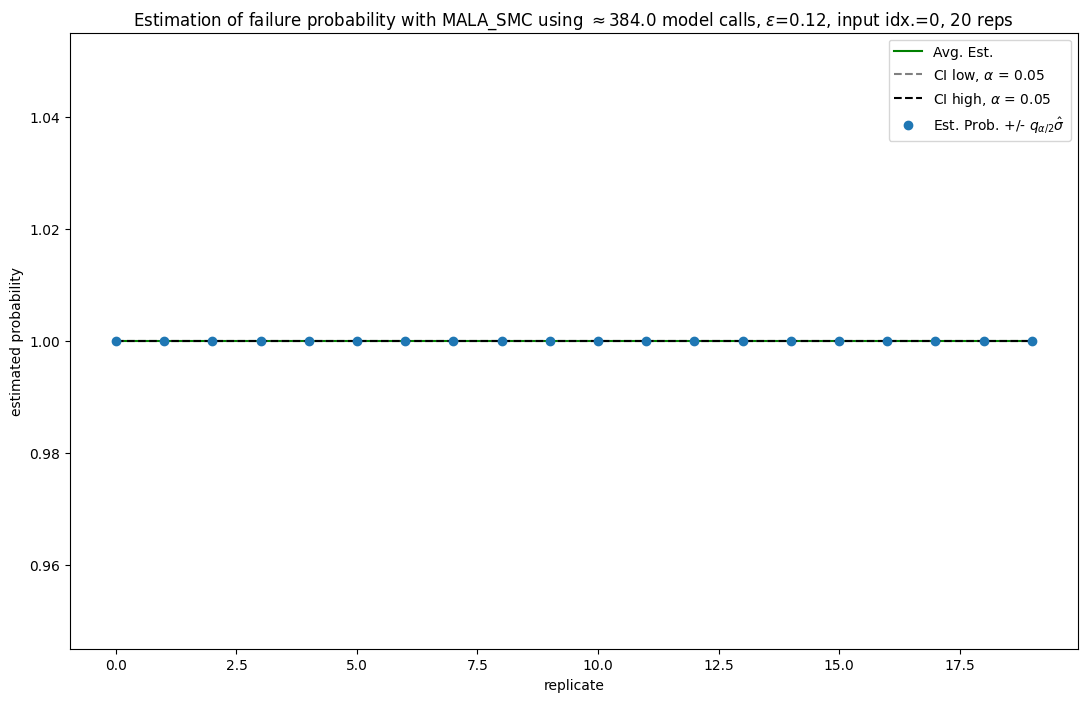

mean est:1.0, std est:0.0
mean calls:384.0
std. re.:0.0
std. rel. adj.:0.0


In [12]:
p_ref, dict_out = run_exp.run_est( X= X, y=y, model=model, input_index=input_index,
                                                repeat_exp=True, track_dt=False, 
                                             method='mala2', dataset_name=dataset,n_rep=20, verbose=0,
                                epsilon_range=epsilon_range, update_aggr_res=True ,track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,alpha=alpha_ref)

In [20]:
agg_res_df

method_name  from_gaussian     N  rho  n_rep    T  epsilon  alpha  \
0     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
1     MALA_SMC           True    50  NaN    100    5     0.18   0.20   
2     MALA_SMC           True    50  NaN    100   10     0.18   0.20   
3     MALA_SMC           True   500  NaN    100   20     0.18   0.20   
4     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
5     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
6     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
7     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
8     MALA_SMC           True   500  NaN    100   20     0.18   0.20   
9     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
10    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
11    MALA_SMC           True   500  NaN      1   20     0.18   0.20   
12    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
13    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
14    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
15    MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
16    MALA_SMC           True  4000  NaN    400  200     0.18   0.20   

    min_rate  mean_time  ...  num_classes   model_name  nb_inputs  \
0       0.15   0.402985  ...         10.0  mnist_model        1.0   
1       0.15   0.157510  ...         10.0  mnist_model        1.0   
2       0.15   0.210056  ...         10.0  mnist_model        1.0   
3       0.15   0.215504  ...         10.0  mnist_model        1.0   
4       0.15   0.416483  ...         10.0  mnist_model        1.0   
5       0.15   0.411512  ...         10.0  mnist_model        1.0   
6       0.15   0.692112  ...         10.0  mnist_model        1.0   
7       0.15   0.758556  ...         10.0  mnist_model        1.0   
8       0.15   0.223448  ...         10.0  mnist_model        1.0   
9       0.15   0.708665  ...         10.0  mnist_model        1.0   
10      0.15   0.360224  ...         10.0  mnist_model        1.0   
11      0.15   0.292626  ...         10.0  mnist_model        1.0   
12      0.15   0.324972  ...         10.0  mnist_model        1.0   
13      0.15   0.217970  ...         10.0  mnist_model        1.0   
14      0.15   0.461533  ...         10.0  mnist_model        1.0   
15      0.15   0.704430  ...         10.0  mnist_model        1.0   
16      0.15   0.541240  ...         10.0  mnist_model        1.0   

                                        raw_logs_path             loc_time  \
0   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_50_34   
1   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_54_07   
2   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_54_07   
3   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_55_25   
4   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_20_41   
5   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_46_05   
6   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_54_33   
7   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_57_19   
8   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T18_00_19   
9   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T20_13_07   
10  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T20_18_48   
11  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_06_50   
12  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_07_14   
13  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_08_18   
14  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_09_28   
15  /home/karimtito/repos/stat_reliability_measure...  2023_11_15T11_52_39   
16  /home/karimtito/repos/stat_reliability_measure...  2023_11_15T11_54_58   

                                         exp_log_path  exp

In [13]:
agg_res_df = pd.read_csv('../logs/exp_model_imagenet/aggr_res.csv')
ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),('n_rep',n_rep_ref,'='),
                                                    ('epsilon',epsilon_range[0],'='),
        ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
p_ref,std_ref

FileNotFoundError: [Errno 2] No such file or directory: '../logs/exp_model_imagenet/aggr_res.csv'

In [14]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(smc_pyt2)
reload(smc_config2)
reload(t_u2)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(is_pyt)
reload(is_config)
reload(mc_config)
reload(mc_pyt)

<module 'stat_reliability_measure.dev.mc.mc_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/mc/mc_pyt.py'>

In [16]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.8],input_index=input_index,
                        alpha=0.2, L_range=[1], only_duplicated=False,p_ref=p_ref,
                         N_range=[50],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )


exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

with parameters in {'N_range': [50], 'T_range': [20], 'ess_alpha_range': [0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: model, img_idx:0,eps:0.12, N: 50: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:06<00:23,  3.29it/s]


KeyboardInterrupt: 

In [19]:
p_ref

1.3623007489660735e-08

model accuracy on sample batch:1.0
Running reliability experiments on architecture model trained on imagnet.
Testing uniform noise pertubation with epsilon in [0.12]
ModelExperimentConfig configuration: 
 config( adversarial_every=1, aggr_res_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagnet/aggr_res.csv, allow_multi_gpu=True, attack=PGD, clip_max=1_0, clip_min=0_0, commit=a1fee62a132a963a7ac7a1b635f90e056e7f6aca, data_dir=/home/karimtito/repos/stat_reliability_measure/data, dataset=imagnet, device=cuda:0, download=True, eps_max=0_12, eps_min=0_12, eps_num=1, epsilon=0_12, exp_log_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagnet/raw_logs/MLS_SMC/MLS_SMC_2023_11_26T20_32_14, exp_name=, export_to_onnx=False, force_train=False, from_gaussian=True, input_start=0, input_stop=1, lirpa_bounds=False, lirpa_cert=False, load_batch_size=128, loc_time=2023_11_26T20_32_14, log_dir=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagne

  0%|          | 0/20 [00:00<?, ?it/s]

Iter =  1  tau_j =  -4.058413505554199 h_mean -5.574882984161377  Calls =  128
Iter =  2  tau_j =  -3.0118682384490967 h_mean -3.6238045692443848  Calls =  1288
Iter =  3  tau_j =  -2.25056529045105 h_mean -2.671372652053833  Calls =  2448
Iter =  4  tau_j =  -1.5954320430755615 h_mean -1.926357626914978  Calls =  3608
Iter =  5  tau_j =  -0.8416838645935059 h_mean -1.3752636909484863  Calls =  4768


  5%|▌         | 1/20 [00:08<02:44,  8.66s/it]

Iter =  6  tau_j =  0.9036769866943359 h_mean -0.4728314280509949  Calls =  5928
Iter =  1  tau_j =  -4.052641868591309 h_mean -5.391543388366699  Calls =  128
Iter =  2  tau_j =  -3.0539674758911133 h_mean -3.608518600463867  Calls =  1288
Iter =  3  tau_j =  -2.2032012939453125 h_mean -2.674311876296997  Calls =  2448
Iter =  4  tau_j =  -1.5488953590393066 h_mean -1.920579433441162  Calls =  3608
Iter =  5  tau_j =  -1.0478386878967285 h_mean -1.4134654998779297  Calls =  4768
Iter =  6  tau_j =  -0.1777559518814087 h_mean -0.6918700337409973  Calls =  5928


 10%|█         | 2/20 [00:19<02:55,  9.75s/it]

Iter =  7  tau_j =  0.2593575716018677 h_mean -0.09407816082239151  Calls =  7088
Iter =  1  tau_j =  -4.296932220458984 h_mean -5.55056619644165  Calls =  128
Iter =  2  tau_j =  -3.1733415126800537 h_mean -3.7751247882843018  Calls =  1288
Iter =  3  tau_j =  -2.3842215538024902 h_mean -2.7565133571624756  Calls =  2448
Iter =  4  tau_j =  -1.424033761024475 h_mean -1.9318615198135376  Calls =  3608
Iter =  5  tau_j =  -0.15860402584075928 h_mean -0.9294309616088867  Calls =  4768


 15%|█▌        | 3/20 [00:28<02:40,  9.41s/it]

Iter =  6  tau_j =  0.316266804933548 h_mean 0.13882574439048767  Calls =  5928
Iter =  1  tau_j =  -4.540762901306152 h_mean -5.682254791259766  Calls =  128
Iter =  2  tau_j =  -3.387286424636841 h_mean -4.033415794372559  Calls =  1288
Iter =  3  tau_j =  -2.3021914958953857 h_mean -2.9090912342071533  Calls =  2448
Iter =  4  tau_j =  -1.7414515018463135 h_mean -2.006369113922119  Calls =  3608
Iter =  5  tau_j =  -1.2933859825134277 h_mean -1.60362708568573  Calls =  4768
Iter =  6  tau_j =  -0.6845400333404541 h_mean -1.0655653476715088  Calls =  5928
Iter =  7  tau_j =  -0.2517715096473694 h_mean -0.40068578720092773  Calls =  7088


 20%|██        | 4/20 [00:40<02:49, 10.58s/it]

Iter =  8  tau_j =  0.21111899614334106 h_mean 0.15115776658058167  Calls =  8248
Iter =  1  tau_j =  -4.351845741271973 h_mean -5.599004745483398  Calls =  128
Iter =  2  tau_j =  -3.275386095046997 h_mean -3.885528802871704  Calls =  1288
Iter =  3  tau_j =  -2.2907800674438477 h_mean -2.877134084701538  Calls =  2448
Iter =  4  tau_j =  -1.7707972526550293 h_mean -1.998146653175354  Calls =  3608
Iter =  5  tau_j =  -1.261178970336914 h_mean -1.6231951713562012  Calls =  4768
Iter =  6  tau_j =  -0.5740042924880981 h_mean -0.955156683921814  Calls =  5928
Iter =  7  tau_j =  -0.4528411626815796 h_mean -0.5264055132865906  Calls =  7088
Iter =  8  tau_j =  -0.4528411626815796 h_mean -0.44904762506484985  Calls =  8248
Iter =  9  tau_j =  -0.3007314205169678 h_mean -0.40281909704208374  Calls =  9408


 25%|██▌       | 5/20 [00:56<03:05, 12.35s/it]

Iter =  10  tau_j =  0.12961113452911377 h_mean -0.062365613877773285  Calls =  10568
Iter =  1  tau_j =  -4.462623596191406 h_mean -5.586043834686279  Calls =  128
Iter =  2  tau_j =  -3.1077136993408203 h_mean -3.9049222469329834  Calls =  1288
Iter =  3  tau_j =  -2.2935962677001953 h_mean -2.7501907348632812  Calls =  2448
Iter =  4  tau_j =  -1.2066174745559692 h_mean -1.8679643869400024  Calls =  3608
Iter =  5  tau_j =  -1.091031551361084 h_mean -1.1135278940200806  Calls =  4768
Iter =  6  tau_j =  -1.026565670967102 h_mean -0.9674873352050781  Calls =  5928


 30%|███       | 6/20 [01:06<02:45, 11.82s/it]

Iter =  7  tau_j =  0.5455036163330078 h_mean -0.05431859940290451  Calls =  7088
Iter =  1  tau_j =  -4.382631778717041 h_mean -5.530682563781738  Calls =  128
Iter =  2  tau_j =  -3.082404136657715 h_mean -3.7986092567443848  Calls =  1288
Iter =  3  tau_j =  -2.022470712661743 h_mean -2.6723132133483887  Calls =  2448
Iter =  4  tau_j =  -1.684144139289856 h_mean -1.8631938695907593  Calls =  3608
Iter =  5  tau_j =  -0.9447965621948242 h_mean -1.2242615222930908  Calls =  4768
Iter =  6  tau_j =  -0.9154627323150635 h_mean -0.9240028262138367  Calls =  5928
Iter =  7  tau_j =  -0.2713671326637268 h_mean -0.7599875926971436  Calls =  7088
Iter =  8  tau_j =  -0.26546603441238403 h_mean -0.2707216739654541  Calls =  8248
Iter =  9  tau_j =  -0.26546603441238403 h_mean -0.2648018002510071  Calls =  9408
Iter =  10  tau_j =  -0.26546603441238403 h_mean -0.2581596374511719  Calls =  10568
Iter =  11  tau_j =  -0.1804460883140564 h_mean -0.1868492215871811  Calls =  11728
Iter =  12  tau

 35%|███▌      | 7/20 [01:30<03:25, 15.81s/it]

Iter =  15  tau_j =  0.3594571352005005 h_mean 0.008058995939791203  Calls =  16368
Iter =  1  tau_j =  -4.3015666007995605 h_mean -5.580999374389648  Calls =  128
Iter =  2  tau_j =  -3.341259717941284 h_mean -3.836780071258545  Calls =  1288
Iter =  3  tau_j =  -2.4008901119232178 h_mean -2.897216796875  Calls =  2448
Iter =  4  tau_j =  -1.8363922834396362 h_mean -2.1305222511291504  Calls =  3608
Iter =  5  tau_j =  -1.2501554489135742 h_mean -1.4780142307281494  Calls =  4768
Iter =  6  tau_j =  -0.5076332092285156 h_mean -0.9594404101371765  Calls =  5928
Iter =  7  tau_j =  -0.025332331657409668 h_mean -0.4491352140903473  Calls =  7088
Iter =  8  tau_j =  -0.025332331657409668 h_mean -0.022062206640839577  Calls =  8248


 40%|████      | 8/20 [01:44<03:00, 15.07s/it]

Iter =  9  tau_j =  0.039655327796936035 h_mean 0.009503493085503578  Calls =  9408
Iter =  1  tau_j =  -4.520143508911133 h_mean -5.658954620361328  Calls =  128
Iter =  2  tau_j =  -3.268601417541504 h_mean -3.9793155193328857  Calls =  1288
Iter =  3  tau_j =  -2.317300319671631 h_mean -2.8549931049346924  Calls =  2448
Iter =  4  tau_j =  -1.7491092681884766 h_mean -1.912799596786499  Calls =  3608
Iter =  5  tau_j =  -1.0165512561798096 h_mean -1.1815744638442993  Calls =  4768
Iter =  6  tau_j =  -0.6153692007064819 h_mean -0.8345072269439697  Calls =  5928
Iter =  7  tau_j =  -0.3428398370742798 h_mean -0.5305978059768677  Calls =  7088
Iter =  8  tau_j =  -0.10913723707199097 h_mean -0.1596478819847107  Calls =  8248


 45%|████▌     | 9/20 [01:58<02:41, 14.66s/it]

Iter =  9  tau_j =  0.13712412118911743 h_mean 0.09753549098968506  Calls =  9408
Iter =  1  tau_j =  -4.388256072998047 h_mean -5.602413177490234  Calls =  128
Iter =  2  tau_j =  -3.1607155799865723 h_mean -3.8427233695983887  Calls =  1288
Iter =  3  tau_j =  -2.3064231872558594 h_mean -2.7072272300720215  Calls =  2448
Iter =  4  tau_j =  -1.2399311065673828 h_mean -1.9411799907684326  Calls =  3608
Iter =  5  tau_j =  -0.6147115230560303 h_mean -0.8626705408096313  Calls =  4768
Iter =  6  tau_j =  -0.6147115230560303 h_mean -0.6147115230560303  Calls =  5928
Iter =  7  tau_j =  -0.6147115230560303 h_mean -0.6147115230560303  Calls =  7088
Iter =  8  tau_j =  -0.6147115230560303 h_mean -0.6124013662338257  Calls =  8248
Iter =  9  tau_j =  -0.6147115230560303 h_mean -0.5951043367385864  Calls =  9408
Iter =  10  tau_j =  -0.31901127099990845 h_mean -0.3837362825870514  Calls =  10568
Iter =  11  tau_j =  -0.24568963050842285 h_mean -0.27757394313812256  Calls =  11728


 50%|█████     | 10/20 [02:16<02:39, 15.95s/it]

Iter =  12  tau_j =  0.09651237726211548 h_mean 0.06017132103443146  Calls =  12888
Iter =  1  tau_j =  -4.249503135681152 h_mean -5.58353328704834  Calls =  128
Iter =  2  tau_j =  -3.14725661277771 h_mean -3.770540237426758  Calls =  1288
Iter =  3  tau_j =  -2.345196485519409 h_mean -2.78702449798584  Calls =  2448
Iter =  4  tau_j =  -1.7603596448898315 h_mean -2.000540256500244  Calls =  3608
Iter =  5  tau_j =  -1.1258498430252075 h_mean -1.590125322341919  Calls =  4768
Iter =  6  tau_j =  -0.6417593955993652 h_mean -0.9418531060218811  Calls =  5928
Iter =  7  tau_j =  -0.43194836378097534 h_mean -0.5197649002075195  Calls =  7088


 55%|█████▌    | 11/20 [02:29<02:13, 14.78s/it]

Iter =  8  tau_j =  0.34966570138931274 h_mean -0.08626358211040497  Calls =  8248
Iter =  1  tau_j =  -4.425393104553223 h_mean -5.728974342346191  Calls =  128
Iter =  2  tau_j =  -3.216118335723877 h_mean -3.889173746109009  Calls =  1288
Iter =  3  tau_j =  -2.3446555137634277 h_mean -2.780388355255127  Calls =  2448
Iter =  4  tau_j =  -1.609825611114502 h_mean -2.0396692752838135  Calls =  3608
Iter =  5  tau_j =  -0.9513275027275085 h_mean -1.289092779159546  Calls =  4768
Iter =  6  tau_j =  -0.41909459233283997 h_mean -0.8068114519119263  Calls =  5928
Iter =  7  tau_j =  -0.11496883630752563 h_mean -0.13806378841400146  Calls =  7088
Iter =  8  tau_j =  -0.002342045307159424 h_mean -0.06229767948389053  Calls =  8248


 60%|██████    | 12/20 [02:42<01:55, 14.50s/it]

Iter =  9  tau_j =  0.09458571672439575 h_mean 0.012911942787468433  Calls =  9408
Iter =  1  tau_j =  -4.262776851654053 h_mean -5.642683029174805  Calls =  128
Iter =  2  tau_j =  -2.9606213569641113 h_mean -3.7620162963867188  Calls =  1288
Iter =  3  tau_j =  -2.1376843452453613 h_mean -2.631714344024658  Calls =  2448
Iter =  4  tau_j =  -1.4786322116851807 h_mean -1.874984860420227  Calls =  3608
Iter =  5  tau_j =  -1.1506967544555664 h_mean -1.3782662153244019  Calls =  4768
Iter =  6  tau_j =  -0.6860763430595398 h_mean -1.0117491483688354  Calls =  5928
Iter =  7  tau_j =  -0.6860763430595398 h_mean -0.6815720796585083  Calls =  7088
Iter =  8  tau_j =  -0.5954999923706055 h_mean -0.6242400407791138  Calls =  8248
Iter =  9  tau_j =  -0.27943694591522217 h_mean -0.25491246581077576  Calls =  9408


 65%|██████▌   | 13/20 [02:56<01:40, 14.36s/it]

Iter =  10  tau_j =  0.6436343789100647 h_mean 0.3130330443382263  Calls =  10568
Iter =  1  tau_j =  -4.389578819274902 h_mean -5.502445220947266  Calls =  128
Iter =  2  tau_j =  -3.149733781814575 h_mean -3.868189811706543  Calls =  1288
Iter =  3  tau_j =  -1.999704360961914 h_mean -2.725905418395996  Calls =  2448
Iter =  4  tau_j =  -1.4440667629241943 h_mean -1.7399741411209106  Calls =  3608
Iter =  5  tau_j =  -1.2469797134399414 h_mean -1.2731109857559204  Calls =  4768
Iter =  6  tau_j =  -0.4800236225128174 h_mean -0.8614633083343506  Calls =  5928
Iter =  7  tau_j =  -0.12411844730377197 h_mean -0.2569052577018738  Calls =  7088
Iter =  8  tau_j =  -0.12411844730377197 h_mean -0.12411844730377197  Calls =  8248
Iter =  9  tau_j =  -0.12411844730377197 h_mean -0.12379070371389389  Calls =  9408
Iter =  10  tau_j =  -0.08216714859008789 h_mean -0.11771117895841599  Calls =  10568


 70%|███████   | 14/20 [03:10<01:25, 14.25s/it]

Iter =  11  tau_j =  0.15064537525177002 h_mean -0.05519647151231766  Calls =  11728
Iter =  1  tau_j =  -4.388624668121338 h_mean -5.679998397827148  Calls =  128
Iter =  2  tau_j =  -3.246546745300293 h_mean -3.898176908493042  Calls =  1288
Iter =  3  tau_j =  -2.440488576889038 h_mean -2.9331774711608887  Calls =  2448
Iter =  4  tau_j =  -1.8392751216888428 h_mean -2.1567211151123047  Calls =  3608
Iter =  5  tau_j =  -1.3421974182128906 h_mean -1.6326966285705566  Calls =  4768
Iter =  6  tau_j =  -1.1074204444885254 h_mean -1.2690155506134033  Calls =  5928
Iter =  7  tau_j =  -0.7300980091094971 h_mean -0.866536021232605  Calls =  7088
Iter =  8  tau_j =  -0.6187587976455688 h_mean -0.6611905097961426  Calls =  8248
Iter =  9  tau_j =  -0.2603806257247925 h_mean -0.5722543001174927  Calls =  9408
Iter =  10  tau_j =  -0.2603806257247925 h_mean -0.23635360598564148  Calls =  10568


 75%|███████▌  | 15/20 [03:24<01:10, 14.17s/it]

Iter =  11  tau_j =  0.12405169010162354 h_mean -0.019719958305358887  Calls =  11728
Iter =  1  tau_j =  -4.500558376312256 h_mean -5.686439037322998  Calls =  128
Iter =  2  tau_j =  -3.150820732116699 h_mean -3.902459144592285  Calls =  1288
Iter =  3  tau_j =  -2.2542362213134766 h_mean -2.802103281021118  Calls =  2448
Iter =  4  tau_j =  -1.5103651285171509 h_mean -1.887098789215088  Calls =  3608
Iter =  5  tau_j =  -0.6694278717041016 h_mean -0.944029688835144  Calls =  4768
Iter =  6  tau_j =  -0.5993852615356445 h_mean -0.6498148441314697  Calls =  5928
Iter =  7  tau_j =  -0.03854036331176758 h_mean -0.47999435663223267  Calls =  7088


 80%|████████  | 16/20 [03:34<00:51, 12.87s/it]

Iter =  8  tau_j =  0.23280936479568481 h_mean 0.015040846541523933  Calls =  8248
Iter =  1  tau_j =  -4.436681747436523 h_mean -5.548433303833008  Calls =  128
Iter =  2  tau_j =  -3.1767001152038574 h_mean -3.921143054962158  Calls =  1288
Iter =  3  tau_j =  -2.1690101623535156 h_mean -2.7470862865448  Calls =  2448
Iter =  4  tau_j =  -1.1255894899368286 h_mean -1.7725815773010254  Calls =  3608
Iter =  5  tau_j =  -1.067096471786499 h_mean -1.0653620958328247  Calls =  4768
Iter =  6  tau_j =  -0.2083316445350647 h_mean -0.8856279253959656  Calls =  5928
Iter =  7  tau_j =  -0.07619106769561768 h_mean -0.14098197221755981  Calls =  7088
Iter =  8  tau_j =  -0.07619106769561768 h_mean -0.05749962106347084  Calls =  8248


 85%|████████▌ | 17/20 [03:46<00:37, 12.37s/it]

Iter =  9  tau_j =  0.12318438291549683 h_mean 0.12318438291549683  Calls =  9408
Iter =  1  tau_j =  -4.332456588745117 h_mean -5.557602405548096  Calls =  128
Iter =  2  tau_j =  -3.2273871898651123 h_mean -3.8349971771240234  Calls =  1288
Iter =  3  tau_j =  -2.2336034774780273 h_mean -2.8031482696533203  Calls =  2448
Iter =  4  tau_j =  -1.9610140323638916 h_mean -2.0653836727142334  Calls =  3608
Iter =  5  tau_j =  -0.87062668800354 h_mean -1.5197570323944092  Calls =  4768
Iter =  6  tau_j =  -0.8244407176971436 h_mean -0.779698371887207  Calls =  5928


 90%|█████████ | 18/20 [03:54<00:22, 11.18s/it]

Iter =  7  tau_j =  0.11841475963592529 h_mean -0.17721912264823914  Calls =  7088
Iter =  1  tau_j =  -4.227223873138428 h_mean -5.580350399017334  Calls =  128
Iter =  2  tau_j =  -3.419748544692993 h_mean -3.843480348587036  Calls =  1288
Iter =  3  tau_j =  -2.449516773223877 h_mean -2.9794487953186035  Calls =  2448
Iter =  4  tau_j =  -1.944603681564331 h_mean -2.1988472938537598  Calls =  3608
Iter =  5  tau_j =  -1.354724645614624 h_mean -1.6968929767608643  Calls =  4768
Iter =  6  tau_j =  -0.5671040415763855 h_mean -1.0564169883728027  Calls =  5928


 95%|█████████▌| 19/20 [04:02<00:10, 10.35s/it]

Iter =  7  tau_j =  0.15243303775787354 h_mean -0.36149483919143677  Calls =  7088
Iter =  1  tau_j =  -4.042178630828857 h_mean -5.620457649230957  Calls =  128
Iter =  2  tau_j =  -3.026599645614624 h_mean -3.6032931804656982  Calls =  1288
Iter =  3  tau_j =  -2.2612812519073486 h_mean -2.6522743701934814  Calls =  2448
Iter =  4  tau_j =  -1.4569441080093384 h_mean -1.8408234119415283  Calls =  3608
Iter =  5  tau_j =  -0.9980568885803223 h_mean -1.1168588399887085  Calls =  4768
Iter =  6  tau_j =  -0.17404675483703613 h_mean -0.693800687789917  Calls =  5928
Iter =  7  tau_j =  -0.11088991165161133 h_mean -0.11829110980033875  Calls =  7088
Iter =  8  tau_j =  -0.11088991165161133 h_mean -0.1105465441942215  Calls =  8248
Iter =  9  tau_j =  -0.11088991165161133 h_mean -0.10882970690727234  Calls =  9408
Iter =  10  tau_j =  -0.06693887710571289 h_mean -0.08719755709171295  Calls =  10568
Iter =  11  tau_j =  -0.06693887710571289 h_mean -0.061697907745838165  Calls =  11728
Iter 

100%|██████████| 20/20 [04:19<00:00, 12.98s/it]

Iter =  13  tau_j =  0.5585472583770752 h_mean 0.3104631304740906  Calls =  14048


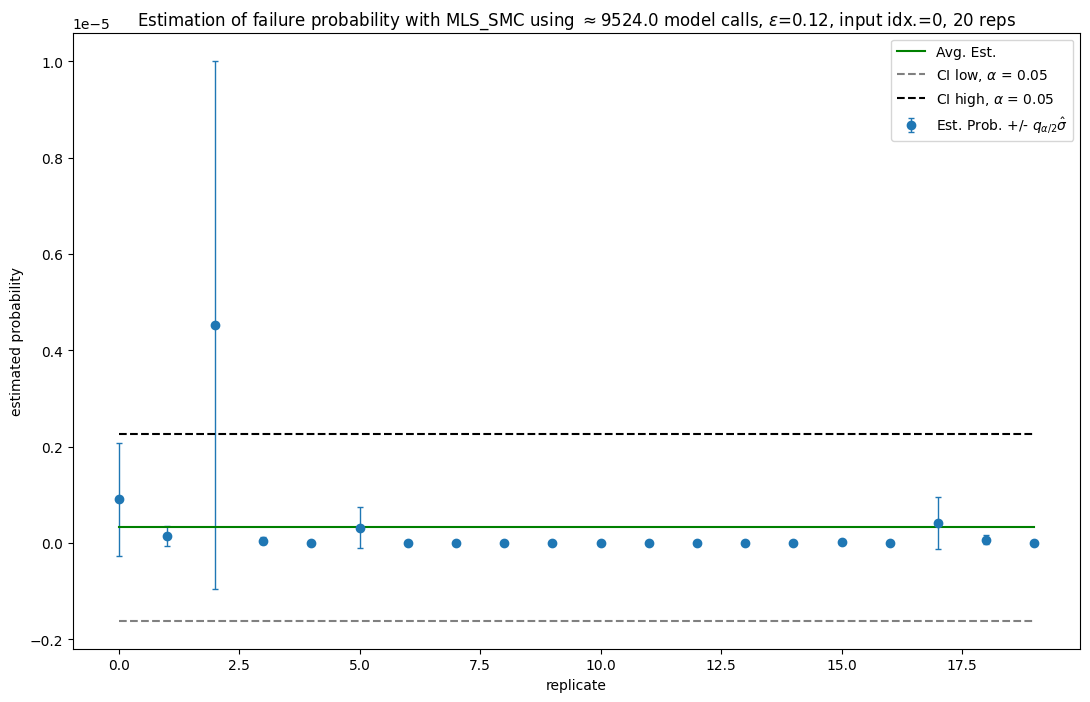

mean est:3.230926446837449e-07, std est:9.878287481687345e-07
mean calls:9524.0
std. re.:9462971.203023529
std. rel. adj.:90125337737.59608
p_fail_mls: 3.230926446837449e-07


In [18]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=20, update_aggr_res=False, 
                         N_range=[128, 
                                  ],T_range=[10],ratio_range=[0.1,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0,p_ref = None)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

In [128]:
zero_latent = torch.zeros((1,X[0].numel())).to(device)
x = is_pyt.mpp_search(grad_f = exp_config.gradG, zero_latent=zero_latent,
                       max_iter=1000,  print_every=10,debug=True)

grad_norm_diff: tensor([4.0733], device='cuda:0')
beta: tensor([0.6802], device='cuda:0')
grad_norm_diff: tensor([7.5394], device='cuda:0')
beta: tensor([0.5739], device='cuda:0')
grad_norm_diff: tensor([8.0806], device='cuda:0')
beta: tensor([0.5596], device='cuda:0')
grad_norm_diff: tensor([7.4415], device='cuda:0')
beta: tensor([0.5679], device='cuda:0')
grad_norm_diff: tensor([8.3972], device='cuda:0')
beta: tensor([0.5684], device='cuda:0')
grad_norm_diff: tensor([7.9206], device='cuda:0')
beta: tensor([0.5651], device='cuda:0')
grad_norm_diff: tensor([7.8546], device='cuda:0')
beta: tensor([0.5590], device='cuda:0')
grad_norm_diff: tensor([7.9639], device='cuda:0')
beta: tensor([0.5680], device='cuda:0')
grad_norm_diff: tensor([7.9363], device='cuda:0')
beta: tensor([0.5714], device='cuda:0')
grad_norm_diff: tensor([8.3866], device='cuda:0')
beta: tensor([0.5674], device='cuda:0')
grad_norm_diff: tensor([7.9684], device='cuda:0')
beta: tensor([0.5695], device='cuda:0')
grad_norm_

In [143]:
exp_config= ExpModelConfig(X=X,y=y,model=model,dataset = 'imagenet', model_name = 'resnet18',data_dir = '../data/ImageNet', model_dir = '../models/ImageNet', device = device,
             torch_seed=42,np_seed=0,random_seed=0,real_uniform=True )

Using real uniform distribution (no atoms)


In [144]:
exp_config.update()

In [131]:
X.requires_grad = True

In [132]:
str(exp_config.normal_cdf_layer)

'NormalToUnifLayer()'

In [133]:
x_0 = x_0.detach()

In [134]:
x_carlini = is_pyt.gaussian_space_attack(x_clean= x_0.unsqueeze(0), y_clean=exp_config.y[0], model=exp_config.model,
                                    epsilon=0.25, n_iter=200, step_size=0.02, device=exp_config.device, real_uniform=False,
                                 normal_cdf_layer= None,dim = x_0.numel(),random_init=False,verbose=1)

                                 
                                 

In [135]:
x_carlini

tensor([[[[ 0.0134,  0.0137, -0.0145,  ..., -0.0135, -0.0136, -0.0332],
          [ 0.0135, -0.0135, -0.0134,  ..., -0.0135,  0.0139,  0.0136],
          [ 0.0141, -0.0140,  0.0135,  ..., -0.0134, -0.0142,  0.0136],
          ...,
          [ 0.0135, -0.0135,  0.0135,  ..., -0.0136,  0.0136, -0.0137],
          [ 0.0154, -0.0135,  0.0134,  ..., -0.0138,  0.0360,  0.0145],
          [-0.0135, -0.0134, -0.0136,  ..., -0.0138, -0.0136, -0.0185]],

         [[ 0.0134,  0.0157, -0.0164,  ..., -0.0135, -0.0135, -0.0139],
          [ 0.0134, -0.0135, -0.0134,  ..., -0.0135,  0.0139,  0.0136],
          [ 0.0166, -0.0134, -0.0134,  ..., -0.0134, -0.0143,  0.0137],
          ...,
          [ 0.0135, -0.0135,  0.0136,  ...,  0.0137,  0.0138, -0.0136],
          [ 0.0136,  0.0141,  0.0134,  ...,  0.0145, -0.0136, -0.0142],
          [-0.0134, -0.0134,  0.0136,  ..., -0.0142, -0.0140,  0.0140]],

         [[ 0.0134,  0.0135,  0.0135,  ..., -0.0135, -0.0135, -0.0141],
          [ 0.0135,  0.0139, -

In [120]:
exp_config.G(x_carlini)

tensor([-2.5659], device='cuda:0')

In [167]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=X,y=y,dataset_name=dataset,search_method='carlini',
                        epsilon_range=epsilon_range, n_rep=20, update_aggr_res=False, save_weights=False,
                         N_range=[4000,],batch_size_range=[250],repeat_exp=False,alpha_CI=0.01,x_clean=x_0,
                         y_clean=exp_config.y[0],
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

with parameters in {'N_range': [4000], 'batch_size_range': [250]}
Starting IS simulation 1/1, with model: model, img_idx:0,eps:0.25, N: 4000: batch_size: 250


  0%|          | 0/20 [00:00<?, ?it/s]

AssertionError: x_clean and y_clean must be provided for Carlini-Wagner attack

In [20]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=300, update_aggr_res=False, save_weights=False,
                         N_range=[2000,],batch_size_range=[128],repeat_exp=False,alpha_CI=0.01,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

with parameters in {'N_range': [2000], 'batch_size_range': [128]}
Starting IS simulation 1/1, with model: model, img_idx:0,eps:0.12, N: 2000: batch_size: 128


  0%|          | 0/300 [00:00<?, ?it/s]

/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
  0%|          | 1/300 [00:03<15:01,  3.01s/it]

  1%|          | 2/300 [00:06<14:54,  3.00s/it]

  1%|          | 3/300 [00:09<14:50,  3.00s/it]

  1%|▏         | 4/300 [00:12<14:51,  3.01s/it]

  2%|▏         | 5/300 [00:15<14:47,  3.01s/it]

  2%|▏         | 5/300 [00:15<15:29,  3.15s/it]


KeyboardInterrupt: 

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.7,0.8],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[3000],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20], [0.7, 0.8], [0.2], [1]]
{'N_range': [3000], 'T_range': [20], 'ess_alpha_range': [0.7, 0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.7: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


mean est:7.125619845282927e-07, std est:0.0
mean calls:1806200.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


mean est:1.429374947292672e-06, std est:0.0
mean calls:1792200.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=1.0709684659104823e-06


with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


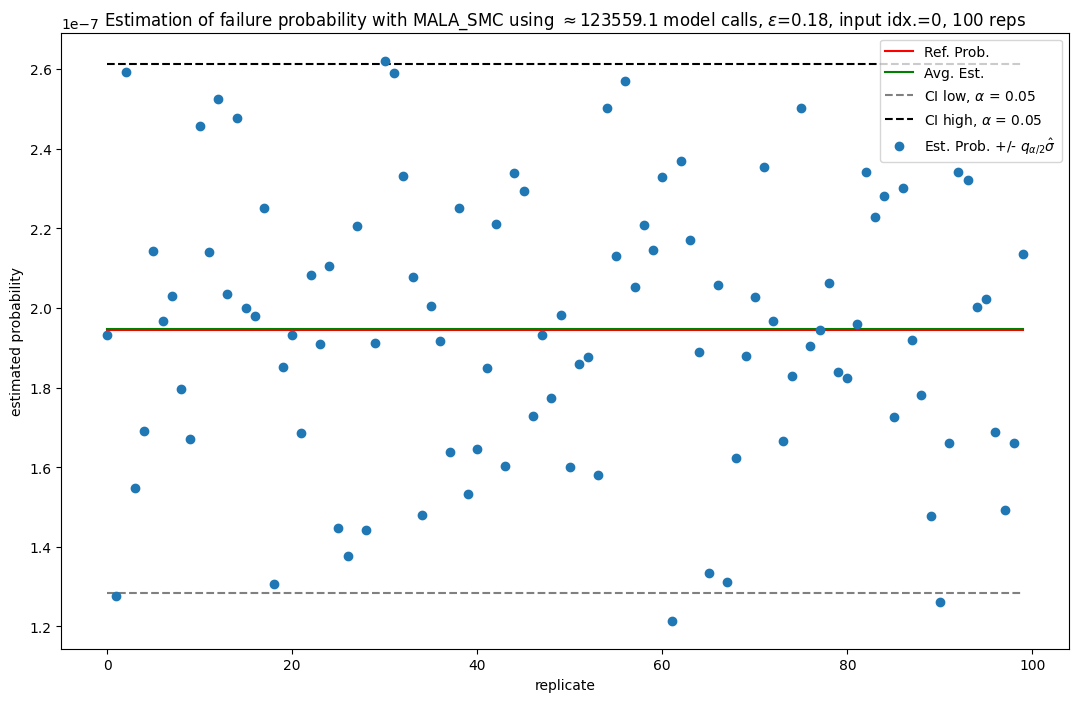

mean est:1.947763398391089e-07, std est:3.3910787382815905e-08
mean calls:123559.1
std. re.:893851.7050677764
std. rel. adj.:110443512211.6399
mean rel. error:0.14067106655076209
std rel. error:0.10307205941389559
stat performance (per 1k calls):12.735490896327468
p_fail_mala=1.947763398391089e-07


In [83]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [ ]:
exp_config.model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
1125858/5e7

0.02251716

In [51]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

[[1000], [10], [0.01]]
{'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.2,steps: 1000: num_iter: 10: stepsize: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


mean est:2.9287436643461935e-10, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999991309993812
std rel. error:0.0
stat performance (per 1k calls):0.0


In [78]:
p_fail_mc, dict_out_mc = run_exp.run_est(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

with parameters in {'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


 20%|██        | 1/5 [00:34<02:16, 34.19s/it]


KeyboardInterrupt: 

In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

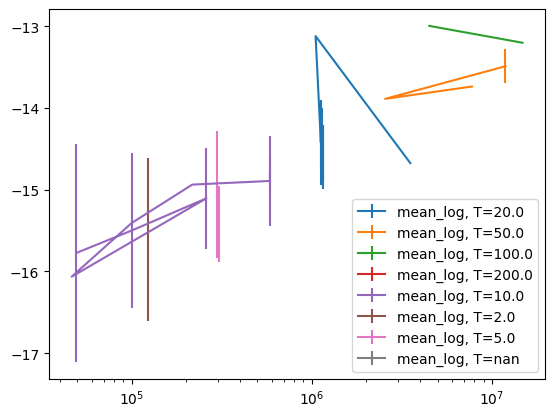

In [68]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

